In [ ]:
%pip install llama-index
%pip install llama-index-core 
%pip install neo4j
%pip install llama-index-graph-stores-neo4j
%pip install llama_index.embeddings.huggingface
%pip install einops

In [ ]:
%pip install --upgrade ipywidgets

Locally Running Graph based database via NEO4j using docker
``` 
docker run -p 7474:7474 -p 7687:7687  -v $PWD/data:/data -v $PWD/plugins:/plugins  --name neo4j-apoc  -e NEO4J_apoc_export_file_enabled=true -e NEO4J_apoc_import_file_enabled=true -e NEO4J_apoc_import_file_use__neo4j__config=true -e NEO4J_PLUGINS='["apoc"]' neo4j:latest


```

In [1]:
#import statment does not matter but needed the pip for >> import einops
from tqdm import tqdm 

from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embed_model = HuggingFaceEmbedding(model_name="nomic-ai/nomic-embed-text-v1.5",
                                    trust_remote_code=True,
                                    cache_folder='./hf_cache')


!!!!!!!!!!!!megablocks not available, using torch.matmul instead
<All keys matched successfully>


In [2]:
from llama_index.llms.ollama import Ollama
llm = Ollama(model="llama3.2:1b", base_url="http://localhost:11434", request_timeout=8000)

In [3]:
import os
from neo4j import GraphDatabase
from llama_index.graph_stores.neo4j import Neo4jPropertyGraphStore

# (running the graph db locally, password exposed not an concern rn!!)
NEO4J_URI = os.getenv("NEO4J_URI", "neo4j://localhost:7687")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME", "neo4j")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "tango-uncle-flag-loyal-fantasy-7396")  

def test_neo4j_connection():
    """Test if Neo4j is accessible."""
    try:
        with GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD)) as driver:
            with driver.session() as session:
                result = session.run("RETURN 'Neo4j is connected!'")
                print(result.single()[0])
    except Exception as e:
        print(f"Neo4j Connection Failed: {e}")

test_neo4j_connection()

# Initialize Neo4jPropertyGraphStore
try:
    graph_store = Neo4jPropertyGraphStore(
        username=NEO4J_USERNAME,
        password=NEO4J_PASSWORD,
        url=NEO4J_URI,
    )
    print("Neo4j Graph Store initialized successfully.")
except Exception as e:
    print(f"Failed to initialize Neo4j Graph Store: {e}")


Neo4j is connected!
Neo4j Graph Store initialized successfully.


In [4]:
from llama_index.core import SimpleDirectoryReader

loader = SimpleDirectoryReader("./dataF/")

documents = loader.load_data()

In [5]:
from IPython.display import Markdown
# first 500 words
display(Markdown(documents[0].text[:500]))

What I Worked On

February 2021

Before college the two main things I worked on, outside of school, were writing and programming. I didn't write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.

The first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing

In [6]:
from llama_index.core import PropertyGraphIndex
from llama_index.core.indices.property_graph import SimpleLLMPathExtractor

In [7]:
import nest_asyncio
nest_asyncio.apply()
data_extractor = SimpleLLMPathExtractor(llm=llm)

index = PropertyGraphIndex.from_documents(documents,
                                          embed_model=embed_model,
                                          kg_extractors=[data_extractor],
                                          property_graph_store=graph_store,
                                          show_progress=True,
                                          )

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/3 [00:00<?, ?it/s]Embedding attempt failed: The size of tensor a (1002) must match the size of tensor b (993) at non-singleton dimension 1
Embedding attempt failed: 'NoneType' object is not subscriptable
Embedding attempt failed: The size of tensor a (1015) must match the size of tensor b (1011) at non-singleton dimension 1
Embedding attempt failed: The size of tensor a (1007) must match the size of tensor b (993) at non-singleton dimension 1
Embedding attempt failed: 'NoneType' object is not subscriptable
Generating embeddings: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


In [8]:
from llama_index.core import Settings

Settings.llm = llm
Settings.embed_model = embed_model

In [9]:
from llama_index.core.indices.property_graph import LLMSynonymRetriever, VectorContextRetriever

In [10]:
synonym_retriever = LLMSynonymRetriever(index.property_graph_store,
                                  llm=llm,
                                  include_text=False,
                                  )

In [11]:
vector_retriever = VectorContextRetriever(index.property_graph_store,
                                          embed_model=embed_model,
                                          include_text=False,
                                        )

In [12]:
retriever = index.as_retriever(sub_retrievers=[synonym_retriever,
                                               vector_retriever],
                               )

In [15]:
context = retriever.retrieve("Who is paul graham?")

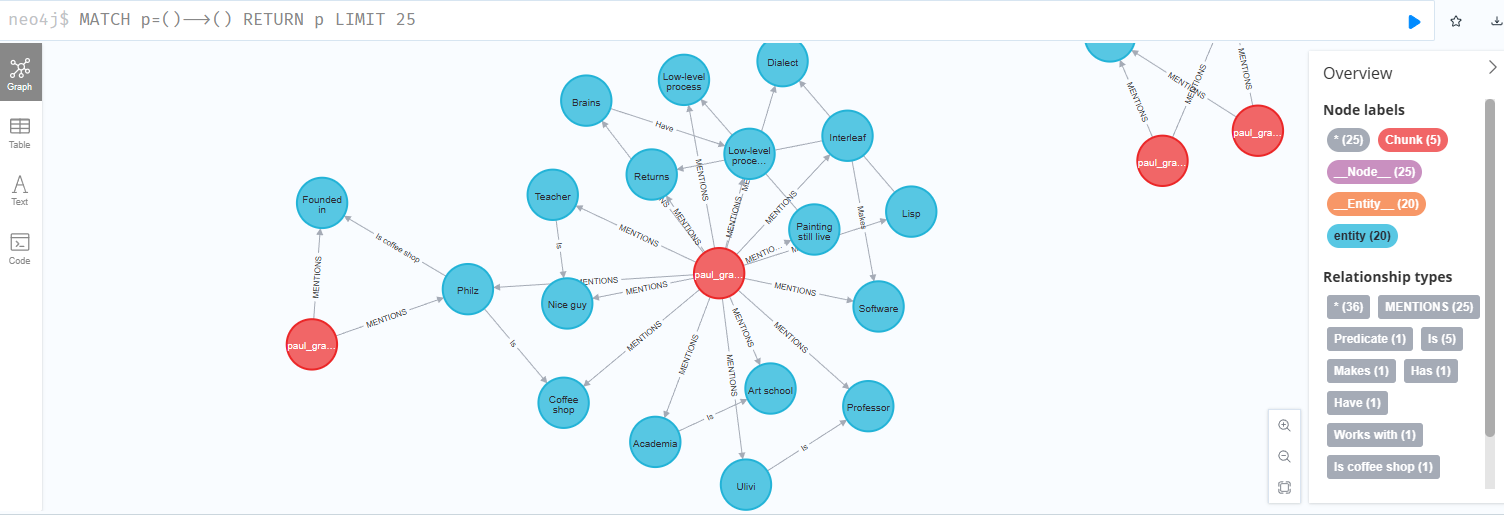

In [3]:
from IPython.display import Image
Image("graphDB.png")


In [16]:
for triplet in context:
    print(triplet.text)

Paul graham -> Is -> Entrepreneur and writer
Options -> Worth $2 million a month -> Paul graham
Graham -> Founded in -> Viaweb
Philz -> Is -> Coffee shop
Philz -> Is coffee shop -> Founded in
Robert -> Trevor -> Started investment firm


In [17]:
query_engine = index.as_query_engine(include_text=True)

response = query_engine.query("Who is paul grams?")

In [18]:
from IPython.display import Markdown, display

display(Markdown(f"{response.response}"))


Based on the provided text, it appears that Paul Graham is an American entrepreneur, writer, and programmer. He is mentioned multiple times throughout the essay as being involved in various ventures, including:

* Co-founding Viaweb with Robert Morris
* Founding Interleaf, a software company that later became a part of Y Combinator's portfolio
* Leaving Interleaf to start his own startup
* Being a Lisp hacker and contributing to the development of Emacs

There is also a mention of him being an entrepreneur and writer, which suggests that he has had a successful career in these fields. Additionally, there are references to him writing essays on topics such as painting, still life, and technology, indicating that he may have been involved in various creative pursuits throughout his life.

In [19]:
print(response.source_nodes[0].node.text)

Here are some facts extracted from the provided text:

Paul graham -> Is -> Entrepreneur and writer
Options -> Worth $2 million a month -> Paul graham
Graham -> Founded in -> Viaweb

It was a huge relief when Yahoo bought us. In principle our Viaweb stock was valuable. It was a share in a business that was profitable and growing rapidly. But it didn't feel very valuable to me; I had no idea how to value a business, but I was all too keenly aware of the near-death experiences we seemed to have every few months. Nor had I changed my grad student lifestyle significantly since we started. So when Yahoo bought us it felt like going from rags to riches. Since we were going to California, I bought a car, a yellow 1998 VW GTI. I remember thinking that its leather seats alone were by far the most luxurious thing I owned.

The next year, from the summer of 1998 to the summer of 1999, must have been the least productive of my life. I didn't realize it at the time, but I was worn out from the effo